In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots, COLORMAPS
from collections import Counter
from matplotlib.lines import Line2D
from aging.organization.dataframes import load_male_long_df, load_female_long_df, DF_PATHS
from tqdm import tqdm

In [2]:
import sklearn.feature_selection as sfs
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, StratifiedKFold, LeaveOneOut, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, cross_val_predict
import random
from sklearn.metrics import accuracy_score

In [3]:
format_plots()
#format_pizza_plots()

In [4]:
def mm_norm_col(column):
    return (column - column.min()) / (column.max() - column.min())

In [5]:
# Log transform function
def log_transform(x):
    return np.log1p(x + 1e-6)

In [6]:
# Create pipeline
pipeline = Pipeline([
    ('log_transform', FunctionTransformer(log_transform)),
    #('scaler', StandardScaler()),
    ('pca', PCA(n_components=11)),
    #("fs", sfs.SelectKBest(sfs.f_classif, k=50)),
    #('svm', SVC(kernel='linear'),
    ('svm', SVC(kernel="rbf"),
    #('svm', SVC(kernel="sigmoid"),
    )
])
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rkf = RepeatedStratifiedKFold(n_splits=5, n_repeats=50, random_state=42)
loo = LeaveOneOut()

In [7]:
cmm = COLORMAPS.ont_male
cmf = COLORMAPS.ont_female
m_df = load_male_long_df(average_weeks=True, merge_size=False, merge_ages=True, df_path=DF_PATHS.usage_male).groupby(['age','mouse']).mean()
f_df = load_female_long_df(average_weeks=True, merge_size=False, filter_female=True, merge_ages=True, df_path=DF_PATHS.usage_female).groupby(['age','mouse']).mean()
m_df['sex'] = 'm'
f_df['sex'] = 'f'

# Combine male and female data into a single DataFrame
combined_df = pd.concat([m_df, f_df])
combined_df.set_index('sex', inplace=True, append=True)

In [8]:
def average_non_overlapping(df):
    new_rows = []
    for mouse, mouse_df in df.groupby(level='mouse'):
        ages = mouse_df.index.get_level_values('age')
        sex = mouse_df.index.get_level_values('sex')[0]
        for i in range(0, len(ages), 2):
            if i + 1 < len(ages):
                avg_row = mouse_df.iloc[i:i + 2].mean()
                new_index = ages[i + 1]
            else:
                avg_row = mouse_df.iloc[i]
                new_index = ages[i]
            new_rows.append((new_index, mouse, sex, *avg_row))
    
    new_index = pd.MultiIndex.from_tuples([(row[0], row[1], row[2]) for row in new_rows], names=['age', 'mouse', 'sex'])
    new_df = pd.DataFrame([row[3:] for row in new_rows], index=new_index, columns=df.columns)
    
    return new_df

In [9]:
def average_overlapping(df):
    new_rows = []
    for mouse, mouse_df in df.groupby(level='mouse'):
        ages = mouse_df.index.get_level_values('age')
        sex = mouse_df.index.get_level_values('sex')[0]
        for i in range(len(ages)):
            if i + 1 < len(ages):
                avg_row = mouse_df.iloc[i:i + 2].mean()
                new_index = ages[i + 1]
            else:
                avg_row = mouse_df.iloc[i]
                new_index = ages[i]
            new_rows.append((new_index, mouse, sex, *avg_row))
    
    new_index = pd.MultiIndex.from_tuples([(row[0], row[1], row[2]) for row in new_rows], names=['age', 'mouse', 'sex'])
    new_df = pd.DataFrame([row[3:] for row in new_rows], index=new_index, columns=df.columns)
    
    return new_df

In [10]:
new_df_non_overlapping = average_non_overlapping(combined_df)
new_df_overlapping = average_overlapping(combined_df)

In [11]:
#df=combined_df.copy()
#df=new_df_non_overlapping.copy()
df=new_df_overlapping

In [12]:
count_per_age_sex = df.groupby(['age', 'sex']).apply(lambda x: x.index.get_level_values('mouse').nunique())

In [13]:
pd.set_option('display.max_rows', None)
count_per_age_sex 

age   sex
4.0   f      19
      m      20
5.0   f      19
      m      20
6.0   f      19
      m      20
7.0   f      19
      m      20
8.0   f      19
      m      20
9.0   f      19
      m      20
10.0  f      19
      m      20
11.0  f      19
      m      20
12.0  f      19
      m      20
13.0  f      19
      m      20
14.0  f      19
      m      20
15.0  f      19
      m      20
16.0  f      19
      m      20
17.0  f      19
      m      20
18.0  f      19
      m      20
19.0  f      19
      m      20
20.0  f      19
      m      18
21.0  f      19
      m      20
22.0  f      19
      m      20
23.0  f      19
      m      19
24.0  f      19
      m      19
25.0  f      19
      m      20
26.0  f      19
      m      20
27.0  f      19
      m      20
29.0  f      19
      m      20
30.0  f      19
      m      19
31.0  f      19
      m      19
32.0  f      19
      m      20
33.0  f      19
      m      19
34.0  f      19
      m      18
35.0  f      19
      m      1

In [14]:
#number of iterations for shuffle
it=100

In [15]:
age2=[]
acc=[]
n=10
#n=16
for i in tqdm(range(it)):
    temp = df.groupby(level=['age', 'sex']).apply(lambda x: x.sample(n=n,replace=False, random_state=i)).reset_index(level=[0, 1],drop=True)
    for age,_df in enumerate(temp.groupby('age')):
        age2.append(_df[0])
        x = _df[1].to_numpy()
        y=_df[1].index.get_level_values('sex')
        acc.append(np.mean(cross_val_score(pipeline, x, y, cv=rkf, n_jobs=-1)))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [34:02<00:00, 20.43s/it]


In [16]:
# create df for plotting
df = pd.DataFrame()
df['acc']=acc
df['ages'] = age2

In [17]:
df.acc.mean()

0.829476

In [18]:
df=combined_df.copy()

In [19]:
sh_ages=[]
sh_acc=[]

for i in tqdm(range(it)):
    temp = df.groupby(level=['age', 'sex']).apply(lambda x: x.sample(n=n,replace=False, random_state=i)).reset_index(level=[0, 1],drop=True)
    for age,_df in enumerate(temp.groupby('age')):
        sh_ages.append(_df[0])
        x = _df[1].to_numpy()
        y=_df[1].index.get_level_values('sex')
        y = y.to_series().sample(frac=1, random_state=i).values
        sh_acc.append(np.mean(cross_val_score(pipeline, x, y, cv=rkf, n_jobs=-1)))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [34:42<00:00, 20.83s/it]


In [20]:
# create df for plotting
df_sh = pd.DataFrame()
df_sh['acc']=sh_acc
df_sh['ages'] = sh_ages

df = pd.DataFrame()
df['acc']=acc
df['ages'] = age2

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and wil

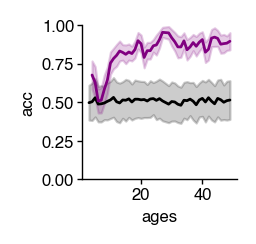

In [21]:
fig, ax = plt.subplots(figsize=(1, 1))
sns.lineplot(data=df_sh, x="ages", y="acc", ax=ax, color='black', estimator='mean', errorbar=('sd', 1))
sns.lineplot(data=df, x="ages", y="acc", ax=ax, color='purple', estimator='mean', errorbar=('sd', 1))
plt.ylim([0.0,1])
plt.legend([],[], frameon=False)
# Set custom x-ticks
#plt.xticks([2,5,10,15,20,25,30,35,])
sns.despine()


In [22]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ '07_25_fvm_sex_decoder_line.pdf', bbox_inches='tight')